In [ ]:
# https://medium.com/data-science-community-srm/comparative-study-of-image-segmentation-architectures-using-deep-learning-3743875fd608

## **Setting up YOLOv5 in Google Colab**

In [1]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt comet_ml  # install
import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-358-gc07b9a8b Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.8/78.2 GB disk)


In [2]:
%cd /content
!curl -L "https://universe.roboflow.com/ds/GG8CHiZqp6?key=1CGJVrdTrW" > Brain_tumor.zip

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   914  100   914    0     0   3261      0 --:--:-- --:--:-- --:--:--  3264
100 50.9M  100 50.9M    0     0  36.8M      0  0:00:01  0:00:01 --:--:-- 60.4M


## Create Directory and unzip Dataset

In [3]:
!mkdir dataset
%cd dataset
!unzip ../Brain_tumor
%cd ..


/content/dataset
Archive:  ../Brain_tumor.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/_annotations.coco.json  
 extracting: test/y154_jpg.rf.fd7dd4d6d829919659ecb1a90d3422b8.jpg  
 extracting: test/y172_jpg.rf.570c1d9489c4e26100d677d6871c69b5.jpg  
 extracting: test/y17_jpg.rf.529ea4876869757178a75c75a2a3cdc4.jpg  
 extracting: test/y192_jpg.rf.a42cf4cfb31c350f07355edfa4fdffff.jpg  
 extracting: test/y193_jpg.rf.79d0ceca42c2066042d0289d23378f52.jpg  
 extracting: test/y193_jpg.rf.8b4ad05b0a3ae369209234559101c6c6.jpg  
 extracting: test/y196_jpg.rf.7f43ebbc0b94cfc686ec04708b9fcae0.jpg  
 extracting: test/y197_jpg.rf.b7532374616c9af58474830d7c1d8069.jpg  
 extracting: test/y203_jpg.rf.2cc56b99cb0beca9c6636d242edaffd4.jpg  
 extracting: test/y206_jpg.rf.3508f8285e65c986622887f19796b712.jpg  
 extracting: test/y20_jpg.rf.87b2a2ea7b6ff13dcfb56c731f9df6ba.jpg  
 extracting: test/y211_jpg.rf.e832b02b3d6dfd23e3d6e937ee456

# **Parser**
Converting dataset annotations from COCO format, stored in a single .coco.json file per folder, into YOLO format. The script processes each image in the dataset, extracting bounding box information and polygon points for segmentation. The converted annotations are saved in individual .txt files, corresponding to each image, in the respective labels folder within train, valid, and test directories.

In [5]:
%cd /content/dataset
import json
import os

def convert_coco_to_yolo(coco_json_path, output_dir):
    # Load the COCO dataset
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    categories = {cat['id']: cat for cat in coco_data['categories']}
    images = {img['id']: img for img in coco_data['images']}
    annotations = coco_data['annotations']

    # Create output directories if they don't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Process each image
    for img_id, image in images.items():
        image_filename = image['file_name']
        output_file_path = os.path.join(output_dir, image_filename.replace('.jpg', '.txt'))

        # Open output file for writing
        with open(output_file_path, 'w') as f:
            # Filter annotations for this image
            img_annotations = [ann for ann in annotations if ann['image_id'] == img_id]

            for ann in img_annotations:
                class_id = ann['category_id']

                # Calculate YOLO-format bounding box
                if ann.get('bbox'):
                    x, y, width, height = ann['bbox']
                    x_center = (x + width / 2) / image['width']
                    y_center = (y + height / 2) / image['height']
                    width /= image['width']
                    height /= image['height']

                    bbox_str = f"{x_center} {y_center} {width} {height}"
                else:
                    bbox_str = f"-1 -1 -1 -1"  # Default if bbox is not available

                # Write class ID, bounding box information, and normalized polygon points
                if ann['segmentation']:
                    for polygon in ann['segmentation']:
                        normalized_polygon = []
                        for i in range(0, len(polygon), 2):
                            px = polygon[i] / image['width']
                            py = polygon[i + 1] / image['height']
                            normalized_polygon.extend([px, py])
                        polygon_str = ' '.join(map(str, normalized_polygon))
                        f.write(f"{class_id} {bbox_str} {polygon_str}\n")
                else:
                    # If no polygon points, write only class ID and bounding box information
                    f.write(f"{class_id} {bbox_str}\n")

# Example usage:
folders = ['train', 'valid', 'test']
for folder in folders:
    coco_json_path = os.path.join(folder, '_annotations.coco.json')
    output_dir = os.path.join(folder, 'labels')
    convert_coco_to_yolo(coco_json_path, output_dir)


/content/dataset


## Organizing Dataset:
Images were in the folder train, valid and test. Needed to move the images of each folder in the folder images within the same folder like /train/images

In [6]:
%cd /content

import shutil
import os

folders = ['train', 'valid', 'test']

for folder in folders:
  # Source directory for images
  source_dir = os.path.join('dataset', folder)

  # Destination directory for images
  destination_dir = os.path.join('dataset', folder, 'images')

  # Create the destination directory if it doesn't exist
  if not os.path.exists(destination_dir):
      os.makedirs(destination_dir)

  # Iterate over files in the source directory
  for filename in os.listdir(source_dir):
      source_path = os.path.join(source_dir, filename)
      destination_path = os.path.join(destination_dir, filename)

      # Check if the item is a file (and presumably an image)
      if os.path.isfile(source_path) and filename.lower().endswith(('.jpg', '.jpeg', '.png')):
          # Move the file to the destination directory
          shutil.move(source_path, destination_path)

/content


# **.Yaml file**
This code snippet creates a Brain_tumor.yaml file containing paths to your training, validation, and test datasets, along with the class names for different classes.

In [7]:
%cd /content
yaml_content = """\
train: /content/dataset/train/images
val: /content/dataset/valid/images
test: /content/dataset/test/images
names:
  0: brain-tumor
  1: tumor

"""

# Define the path to save the data.yaml file
data_yaml_path = '../content/yolov5/data/Brain_tumor.yaml'

# Write the YAML content to the file
with open(data_yaml_path, 'w') as file:
    file.write(yaml_content)


/content


# Training

In [11]:
# %cd /content/yolov5
# !python segment/train.py --img 640 --batch 16 --epochs 70 --data Brain_tumor.yaml --weights yolov5s-seg.pt --cache

/content/yolov5
2024-08-25 07:01:56.651003: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 07:01:56.671035: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-25 07:01:56.677210: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
segment/train: weights=yolov5s-seg.pt, cfg=, data=Brain_tumor.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=70, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_

# **Load Your Saved Model(Trained on custom Dataset) **
As I have already trained and saved model on this Dataset, So I'm loading my saved model

In [ ]:
%cd /content/yolov5
import torch
model_path = '/content/drive/MyDrive/models/Brain_tumor_segmentation_model.pt'

# Load the model
torch.load(model_path)



# inference on the images
This command runs inference on a test image using a your trained segmentation model with specified weights and settings.

In [3]:
%cd /content/yolov5
!python segment/predict.py --weights /content/yolov5/runs/train-seg/exp3/weights/best.pt --img 640 --conf 0.25 --source /content/dataset/test/images/y206_jpg.rf.3508f8285e65c986622887f19796b712.jpg

/content/yolov5
segment/predict: weights=['/content/yolov5/runs/train-seg/exp3/weights/best.pt'], source=/content/dataset/test/images/y206_jpg.rf.3508f8285e65c986622887f19796b712.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/predict-seg, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1, retina_masks=False
YOLOv5 🚀 v7.0-358-gc07b9a8b Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 165 layers, 7401119 parameters, 0 gradients, 25.7 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/dataset/test/images/y206_jpg.rf.3508f8285e65c986622887f19796b712.jpg: 640x640 1 tumor, 14.8ms
Speed: 0.6ms pre-process, 14.8ms inference, 638.6ms NMS per i

# Output

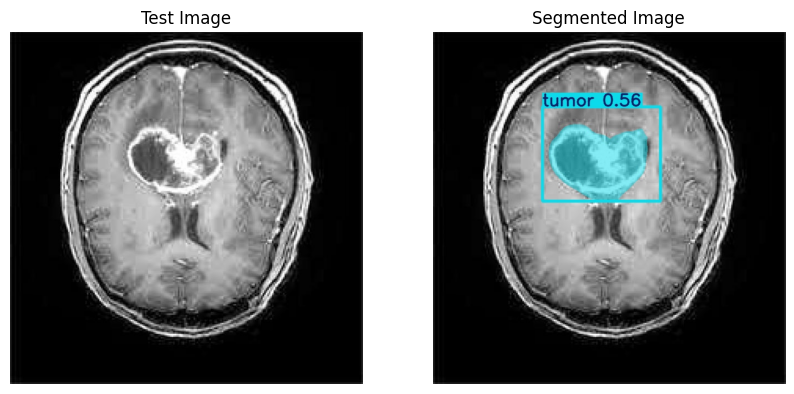

In [4]:
import matplotlib.pyplot as plt
import cv2

# Load the test image
test_image_path = '/content/dataset/test/images/y206_jpg.rf.3508f8285e65c986622887f19796b712.jpg'
test_image = cv2.imread(test_image_path)
test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

# Load the segmented image (assuming it's saved after inference)
segmented_image_path = '/content/yolov5/runs/predict-seg/exp3/y206_jpg.rf.3508f8285e65c986622887f19796b712.jpg'  # Update the path if needed
segmented_image = cv2.imread(segmented_image_path)
segmented_image_rgb = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)

# Display the images side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(test_image_rgb)
plt.title('Test Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image_rgb)
plt.title('Segmented Image')
plt.axis('off')

plt.show()



# Save Your Trained Model

In [16]:
# Mount Google Drive
from google.colab import drive

# Use a try-except block to handle potential errors during mounting
try:
  drive.mount('/content/drive')
except ValueError:
  # If the mountpoint is not empty, clear it and try again
  !rm -rf /content/drive
  drive.mount('/content/drive')

# --- Your existing model saving code ---
import os
import torch

# Define the save path within your Drive
save_folder = '/content/drive/MyDrive/models'
os.makedirs(save_folder, exist_ok=True) # Ensure the directory exists
save_path = os.path.join(save_folder, 'Brain_tumor_segmentation_model.pt')

trained_model_path = '/content/yolov5/runs/train-seg/exp3/weights/best.pt'
torch.save(torch.load(trained_model_path), save_path)

Mounted at /content/drive
